# SWAN declarative example

In this notebook we will run SWAN entirely from a model runtime and config entirely
declared in a yaml file. We only plot some model settings to visualise before creating
the model workspace

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import yaml

import warnings
warnings.filterwarnings('ignore')

## Instantiate model

Use a fully-defined config from yaml to instantiate ModelRun with the runtime parameters
and the config definition

In [2]:
# Uncoment below to view the contents of the yaml file

# !cat example_declarative.yml

In [3]:
from rompy.model import ModelRun

conf = yaml.load(open("example_declarative.yml"), Loader=yaml.Loader)
run = ModelRun(**conf)
run

ModelRun(run_id='run1', period=TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=3600), include_end=True), output_dir='example_declarative', config=SwanConfigComponents(model_type='swanconfig', template='/source/csiro/rompy/rompy/templates/swancomp', checkout='main', cgrid=REGULAR(model_type='regular', spectrum=SPECTRUM(model_type='spectrum', mdc=36, flow=0.04, fhigh=1.0, msc=None, dir1=None, dir2=None), grid=GRIDREGULAR(model_type='gridregular', xp=110.0, yp=-35.2, alp=4.0, xlen=7.5, ylen=12.5, mx=14, my=24, suffix='c')), startup=STARTUP(model_type='startup', project=PROJECT(model_type='project', name='Test declarative', nr='run1', title1='Declarative definition of a Swan config with rompy', title2=None, title3=None), set=SET(model_type='set', level=0.0, nor=None, depmin=0.05, maxmes=None, maxerr=None, grav=None, rho=None, cdcap=None, inrhog=None, hsrerr=None, direction

### QC config

Plot model grid and data to QC before generating the workspace

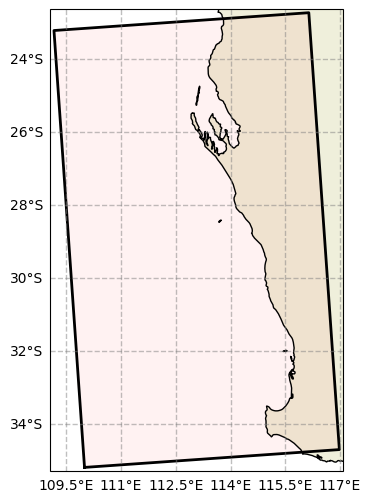

In [4]:
# Model grid

fig, ax = run.config.grid.plot(fscale=6)

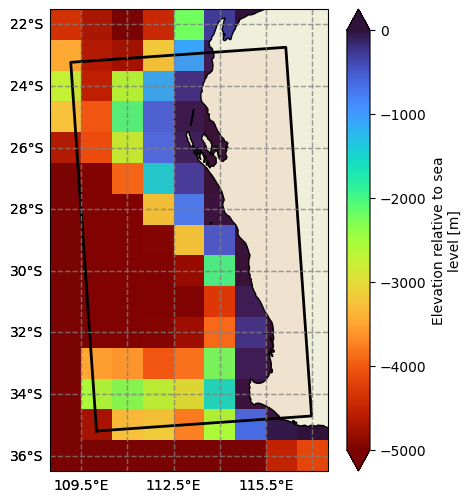

In [5]:
# Model bathy

bottom = run.config.inpgrid.bottom
bottom._filter_grid(run.config.grid) # This isn't necessary since cropping is done by the SwanConfigComponents, it is just for plotting
fig, ax = bottom.plot(param="elevation", vmin=-5000, vmax=0, cmap="turbo_r", figsize=(5, 6))
fig, ax = run.config.grid.plot(ax=ax)

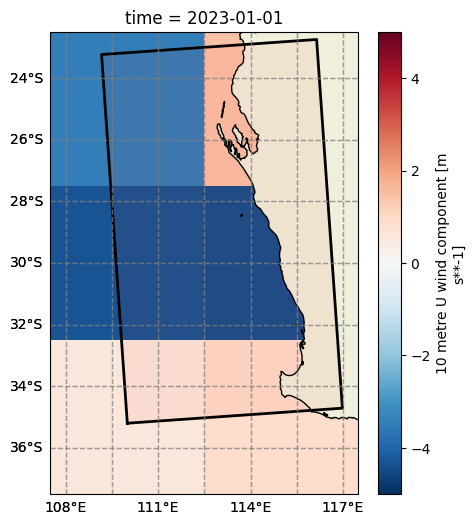

In [6]:
# Model winds

wind = run.config.inpgrid.input[0]
wind._filter_grid(run.config.grid) # This isn't necessary since cropping is done by the SwanConfigComponents, it is just for plotting
fig, ax = wind.plot(param="u10", isel={"time": 0}, vmin=-5, vmax=5, cmap="RdBu_r", figsize=(5, 6))
fig, ax = run.config.grid.plot(ax=ax)

## Run the model

In [7]:
run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: run1
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: example_declarative
config: <class 'rompy.swan.config.SwanConfigComponents'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example_declarative
INFO:rompy.swan.data:	Writing bottom to example_declarative/run1/bottom.grd
INFO:rompy.swan.data:	Writing wind to example_declarative/run1/wind.grd
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in example_declarative
INFO:rompy.model:-----------------------------------------------------


'/source/csiro/rompy/notebooks/swan/example_declarative/run1'

### Check the workspace

In [8]:
modeldir = Path(run.output_dir) / run.run_id

sorted(modeldir.glob("*"))

[PosixPath('example_declarative/run1/INPUT'),
 PosixPath('example_declarative/run1/bottom.grd'),
 PosixPath('example_declarative/run1/wind.grd')]

In [9]:
input = modeldir / "INPUT"
print(input.read_text())

! Rompy SwanConfig
! Template: /source/csiro/rompy/rompy/templates/swancomp
! Generated: 2023-11-02 11:15:18.822557 on rafael-XPS by rguedes


! Startup -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PROJECT name='Test declarative' nr='run1' title1='Declarative definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM

! Computational Grid --------------------------------------------------------------------------------------------------------------------------------------------------------------


CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.5 ylenc=12.5 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0

! Input Grids ---------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Run the model


In [10]:
!docker run  -v ./example_declarative/run1:/home oceanum/swan:4141 swan.exe


 SWAN is preparing computation

 iteration    1; sweep 1
+iteration    1; sweep 2
+iteration    1; sweep 3
+iteration    1; sweep 4
 not possible to compute, first iteration

 iteration    2; sweep 1
+iteration    2; sweep 2
+iteration    2; sweep 3
+iteration    2; sweep 4
 accuracy OK in  45.28 % of wet grid points ( 95.00 % required)

 iteration    3; sweep 1
+iteration    3; sweep 2
+iteration    3; sweep 3
+iteration    3; sweep 4
 accuracy OK in   0.79 % of wet grid points ( 95.00 % required)

 iteration    4; sweep 1
+iteration    4; sweep 2
+iteration    4; sweep 3
+iteration    4; sweep 4
 accuracy OK in  56.70 % of wet grid points ( 95.00 % required)

 iteration    5; sweep 1
+iteration    5; sweep 2
+iteration    5; sweep 3
+iteration    5; sweep 4
 accuracy OK in  20.87 % of wet grid points ( 95.00 % required)

 iteration    6; sweep 1
+iteration    6; sweep 2
+iteration    6; sweep 3
+iteration    6; sweep 4
 accuracy OK in  85.83 % of wet grid points ( 95.00 % required)


## Plot outputs

In [11]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from wavespectra import read_ncswan
from wavespectra.core.swan import read_tab

pd.set_option("display.notebook_repr_html", False)

In [12]:
modeldir = Path(run.output_dir) / run.run_id

sorted(modeldir.glob("*"))

[PosixPath('example_declarative/run1/INPUT'),
 PosixPath('example_declarative/run1/PRINT'),
 PosixPath('example_declarative/run1/bottom.grd'),
 PosixPath('example_declarative/run1/hotfile_20230102T000000.txt'),
 PosixPath('example_declarative/run1/norm_end'),
 PosixPath('example_declarative/run1/swangrid.nc'),
 PosixPath('example_declarative/run1/swaninit'),
 PosixPath('example_declarative/run1/swanspec.nc'),
 PosixPath('example_declarative/run1/swantable.txt'),
 PosixPath('example_declarative/run1/wind.grd')]

In [13]:
# Gridded output

dsgrid = xr.open_dataset(modeldir / run.config.output.block.fname)
dsgrid

<xarray.Dataset>
Dimensions:    (time: 25, yc: 25, xc: 15)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
    longitude  (yc, xc) float32 ...
    latitude   (yc, xc) float32 ...
Dimensions without coordinates: yc, xc
Data variables:
    depth      (time, yc, xc) float32 ...
    xwnd       (time, yc, xc) float32 ...
    ywnd       (time, yc, xc) float32 ...
    hs         (time, yc, xc) float32 ...
    tps        (time, yc, xc) float32 ...
    theta0     (time, yc, xc) float32 ...
Attributes:
    Conventions:             CF-1.5
    History:                 Created with agioncmd version 1.5
    Directional_convention:  nautical
    project:                 Test declarative
    run:                     run1

In [14]:
# Spectra output

dspec = read_ncswan(modeldir / run.config.output.specout.fname)
dspec

<xarray.Dataset>
Dimensions:  (time: 25, site: 3, freq: 35, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T01:00:00 ... 2023-01-02
  * freq     (freq) float32 0.04 0.04397 0.04834 0.05314 ... 0.8275 0.9097 1.0
  * dir      (dir) float32 261.0 251.0 241.0 231.0 ... 301.0 291.0 281.0 271.0
  * site     (site) int64 1 2 3
Data variables:
    lon      (site) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    lat      (site) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 dask.array<chunksize=(25, 3, 35, 36), meta=np.ndarray>
    dpt      (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
    wspd     (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
    wdir     (time, site) float32 dask.array<chunksize=(25, 3), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.5
    History:                 Created with agioncmd version 1.5
    Directional_convention:  nautical
    project:                 Test declarative
    model:                   41.41
    run:                     run1

In [15]:
os.system(f"head -n 15 {modeldir / run.config.output.table.fname}")

%
%
% Run:run1  Table:pts               SWAN version:41.41
%
%       Time               Hsig          Hswell        Dir           TPsmoo        Tm01     
%       [ ]                [m]           [m]           [degr]        [sec]         [sec]    
%
20230101.000000          0.61126       0.00002       183.186        3.6992        2.7202 
20230101.000000          1.07937       0.03900       176.467        4.9832        3.7063 
20230101.000000         -9.00000      -9.00000        -9.000       -9.0000       -9.0000 
20230101.010000          0.61275       0.00002       182.850        3.7210        2.7083 
20230101.010000          1.07086       0.03935       176.350        5.0704        3.6928 
20230101.010000         -9.00000      -9.00000        -9.000       -9.0000       -9.0000 
20230101.020000          0.61664       0.00002       182.787        3.7145        2.7083 
20230101.020000          1.06328       0.03973       176.565        5.0631        3.6886 


0

In [16]:
# Timeseries output (keep 1st site only)

df = read_tab(modeldir / run.config.output.table.fname)

df["time"] = df.index
df = df.drop_duplicates("time", keep="first").drop("time", axis=1)
df.head()

                        Hsig   Hswell      Dir  TPsmoo    Tm01
time                                                          
2023-01-01 00:00:00  0.61126  0.00002  183.186  3.6992  2.7202
2023-01-01 01:00:00  0.61275  0.00002  182.850  3.7210  2.7083
2023-01-01 02:00:00  0.61664  0.00002  182.787  3.7145  2.7083
2023-01-01 03:00:00  0.61837  0.00001  182.792  3.7198  2.7177
2023-01-01 04:00:00  0.62287  0.00001  182.762  3.7230  2.7247

### Plot model depth

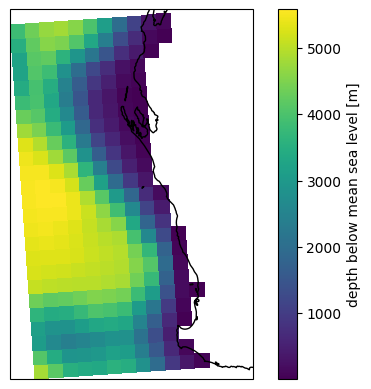

In [17]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
p = dsgrid.depth.isel(time=0, drop=True).plot(ax=ax, x="longitude", y="latitude")
ax.coastlines();

### Plot gridded Hs

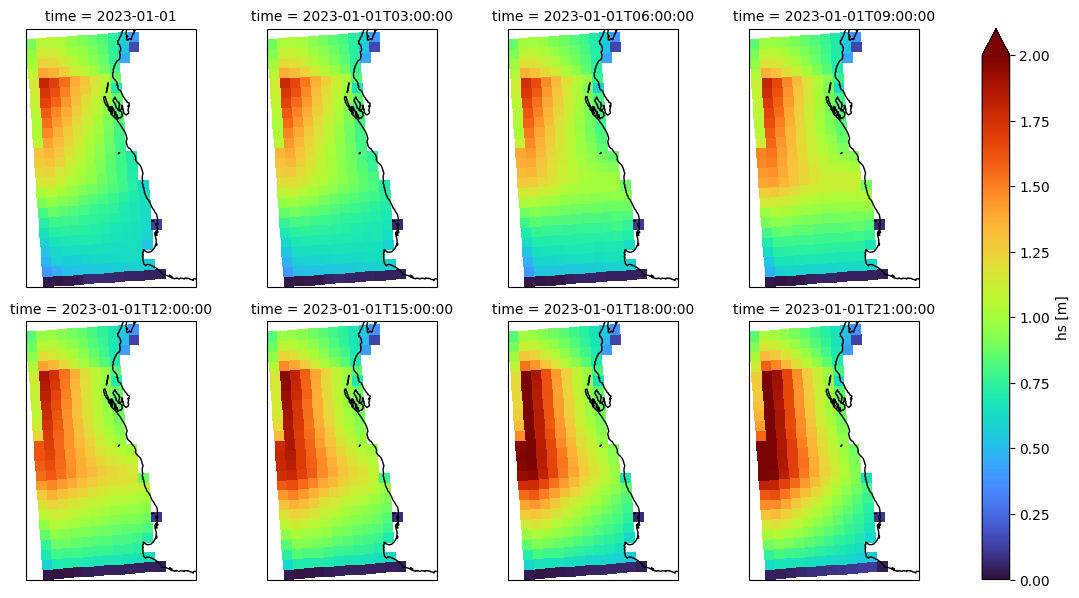

In [18]:
f = dsgrid.hs.isel(time=slice(0, -1, 3)).plot(
    x="longitude",
    y="latitude",
    col="time",
    col_wrap=4,
    vmin=0,
    vmax=2,
    cmap="turbo",
    subplot_kws=dict(projection=ccrs.PlateCarree()),
)
f.map(lambda: plt.gca().coastlines());

### Plot gridded wind

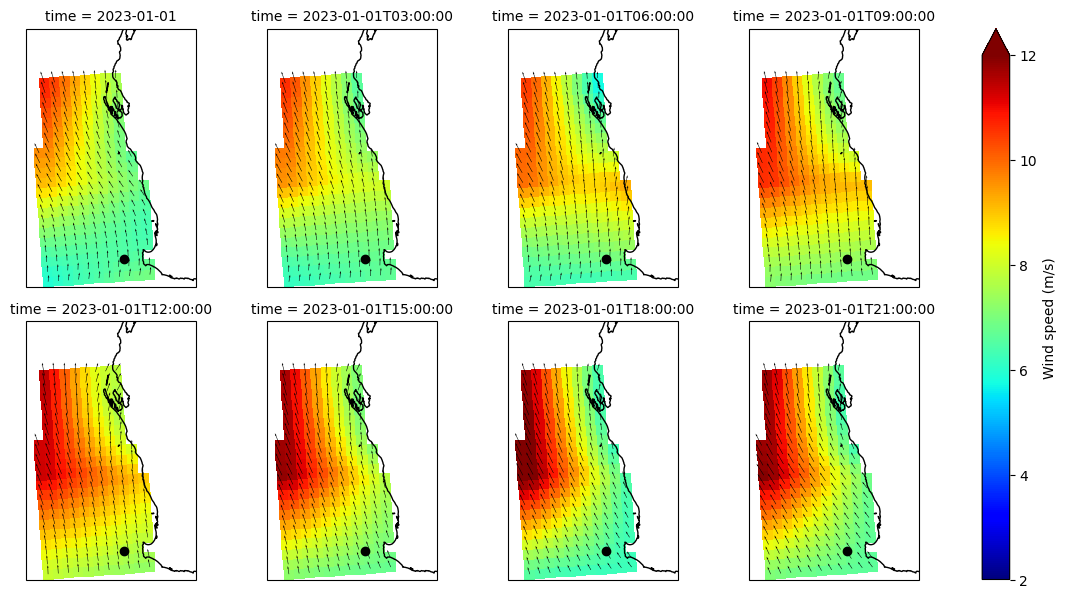

In [19]:
u = dsgrid.xwnd.isel(time=slice(0, -1, 3))
v = dsgrid.ywnd.isel(time=slice(0, -1, 3))
f = np.sqrt(u ** 2 + v ** 2).plot(
    x="longitude",
    y="latitude",
    col="time",
    col_wrap=4,
    vmin=2,
    vmax=12,
    cmap="jet",
    cbar_kwargs={"label": "Wind speed (m/s)"},
    subplot_kws=dict(projection=ccrs.PlateCarree()),
)
for ax, time in zip(f.axs.flat, u.time):
    ax.coastlines()
    ax.quiver(u.longitude, u.latitude, u.sel(time=time), v.sel(time=time), scale=150)
    ax.plot(dspec.isel(site=0).lon, dspec.isel(site=0).lat, "ok")

### Plot spectra

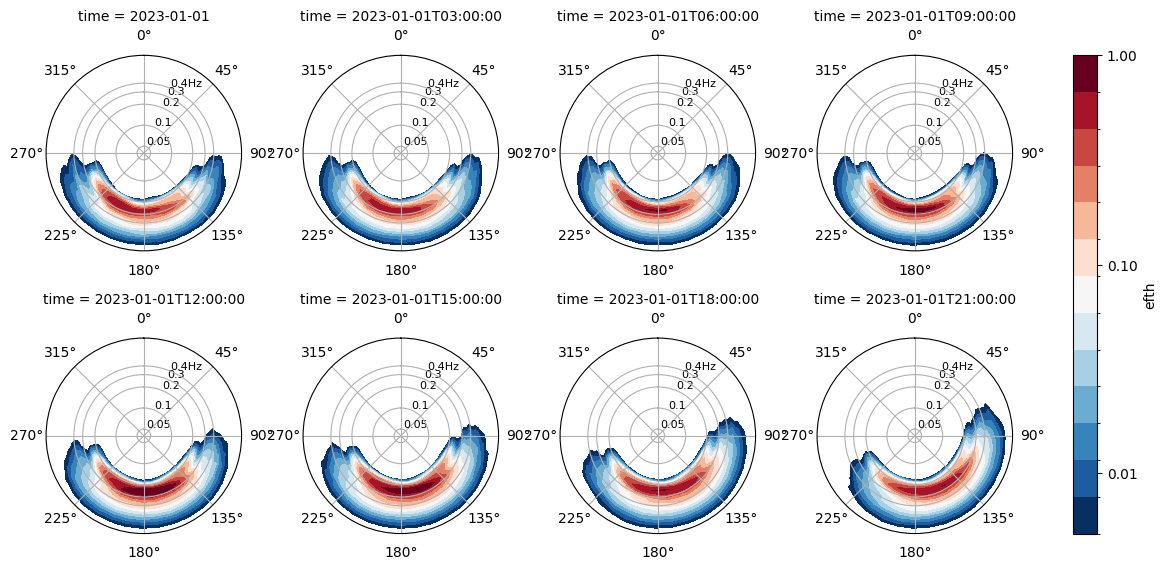

In [20]:
p = dspec.isel(site=0, time=slice(0, -1, 3)).spec.plot(col="time", col_wrap=4)

### Plot timeseries

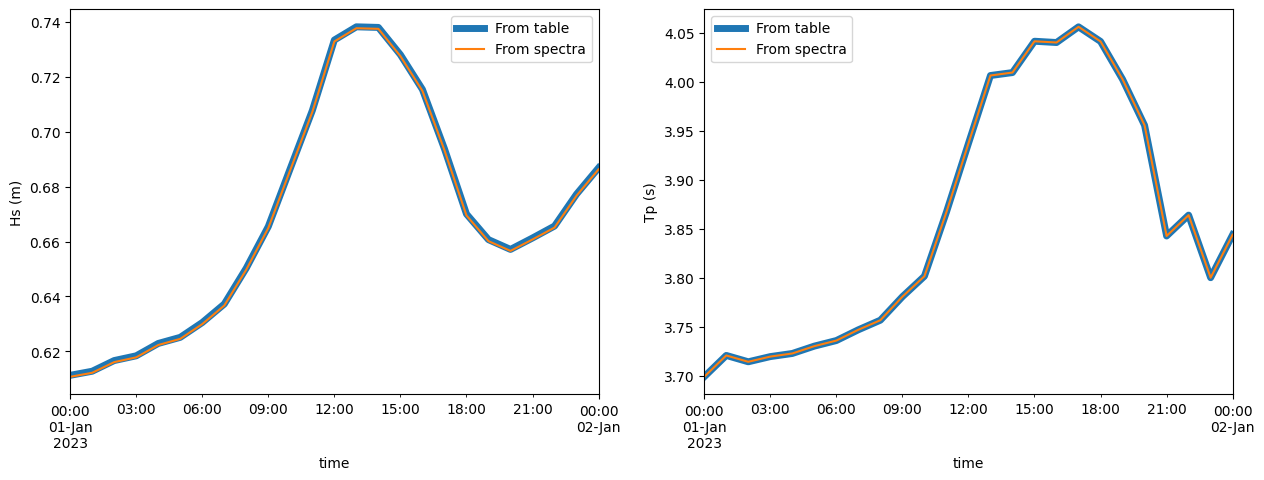

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.Hsig.plot(ax=ax1, label="From table", linewidth=5)
dspec.isel(site=0).spec.hs().to_pandas().plot(ax=ax1, label="From spectra")
ax1.set_ylabel("Hs (m)")
l = ax1.legend()

df.TPsmoo.plot(ax=ax2, label="From table", linewidth=5)
dspec.isel(site=0).spec.tp(smooth=True).to_pandas().plot(ax=ax2, label="From spectra")
ax2.set_ylabel("Tp (s)")
l = ax2.legend()